# Get Data


In [ ]:
! pip install gdown
! gdown --id 1t4Y9GjPB76pUrQDOLTzwooWVycSoS-yU
! unzip /content/Alzheimer_dataset.zip

Streaming output truncated to the last 5000 lines.
 extracting: Alzheimer_dataset/Non_Demented/non_1396.jpg  
 extracting: Alzheimer_dataset/Non_Demented/non_1397.jpg  
 extracting: Alzheimer_dataset/Non_Demented/non_1398.jpg  
 extracting: Alzheimer_dataset/Non_Demented/non_1399.jpg  
 extracting: Alzheimer_dataset/Non_Demented/non_14.jpg  
 extracting: Alzheimer_dataset/Non_Demented/non_140.jpg  
 extracting: Alzheimer_dataset/Non_Demented/non_1400.jpg  
 extracting: Alzheimer_dataset/Non_Demented/non_1401.jpg  
 extracting: Alzheimer_dataset/Non_Demented/non_1402.jpg  
 extracting: Alzheimer_dataset/Non_Demented/non_1403.jpg  
 extracting: Alzheimer_dataset/Non_Demented/non_1404.jpg  
 extracting: Alzheimer_dataset/Non_Demented/non_1405.jpg  
 extracting: Alzheimer_dataset/Non_Demented/non_1406.jpg  
 extracting: Alzheimer_dataset/Non_Demented/non_1407.jpg  
 extracting: Alzheimer_dataset/Non_Demented/non_1408.jpg  
 extracting: Alzheimer_dataset/Non_Demented/non_1409.jpg  
 extract

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]

In [ ]:
try:
    if tf.test.gpu_device_name():
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print('GPU active! -', physical_devices)
    else:
        print('GPU not active!')
except Exception as e:
    print('An error occurred while checking the GPU:', e)

GPU active! - [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Target Value Distribution

A search has been initiated within the folder named 'Alzheimer_dataset'.
There are 2240 images in the Very_Mild_Demented folder.
There are 3200 images in the Non_Demented folder.
There are 64 images in the Moderate_Demented folder.
There are 896 images in the Mild_Demented folder.
The search has been completed.


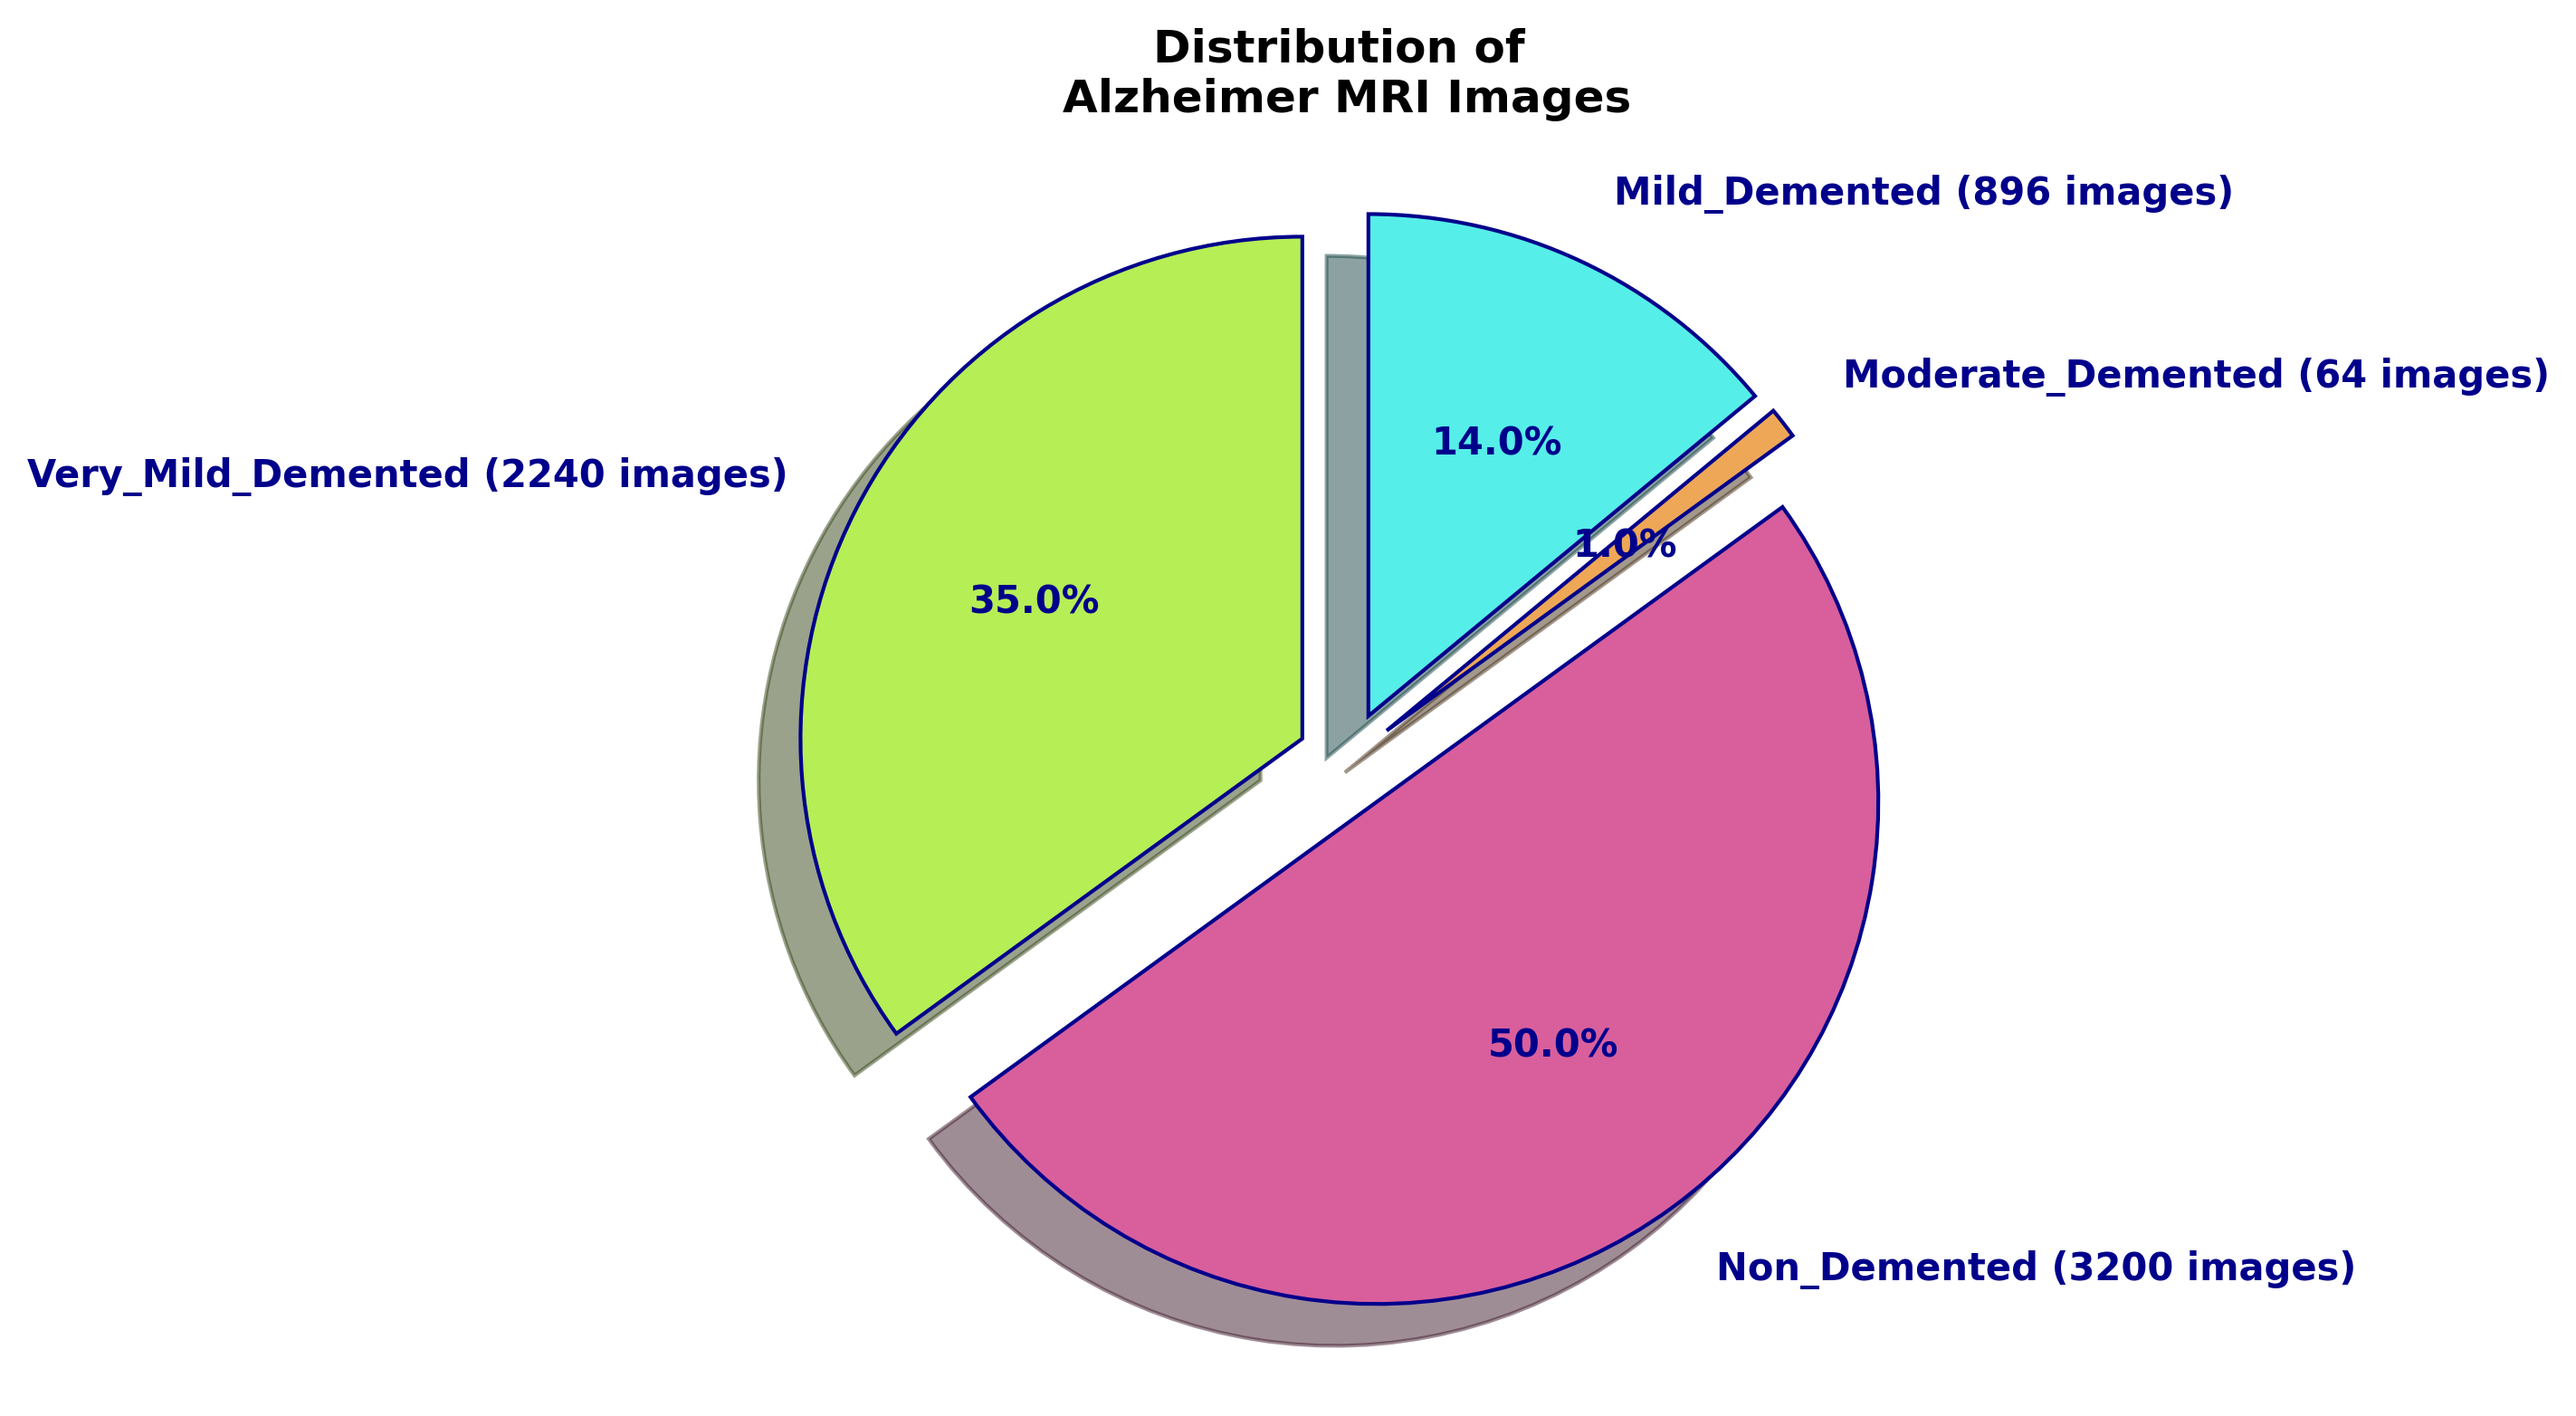

In [ ]:
class_dist = {}
def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    print('\033[92m'+f"A search has been initiated within the folder named '{basename}'."+'\033[0m')
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0
            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()
                if file_ext in image_extensions:
                    count += 1
            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")
    print('\033[92m'+"The search has been completed."+'\033[0m')

    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)
    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]

    plt.pie(values, explode=explode,labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors, textprops={'fontsize': 10, "fontweight" : "bold", "color":"darkblue"},  wedgeprops=
           {'edgecolor':'darkblue'} , labeldistance=1.15)
    plt.title("Distribution of \nAlzheimer MRI Images", size=12, fontweight="bold")

PATH = '/content/Alzheimer_dataset'
image_counter(PATH)

<p style="color: black; background-color: lightsteelblue; border:2px

---

solid black;">As observed in the class distribution, we have an imbalanced dataset. <b>Non Demented MRI class constitutes 50% of the total data with 3200 images</b>, while <b>Moderate Demented MRI class only makes up 1% of the dataset with 64 images.</b></p>

# Generate TensorFlow Dataset

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size = 32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42,)

class_names = data.class_names

Found 6400 files belonging to 4 classes.


<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">MRI Samples for Each Class</h2>

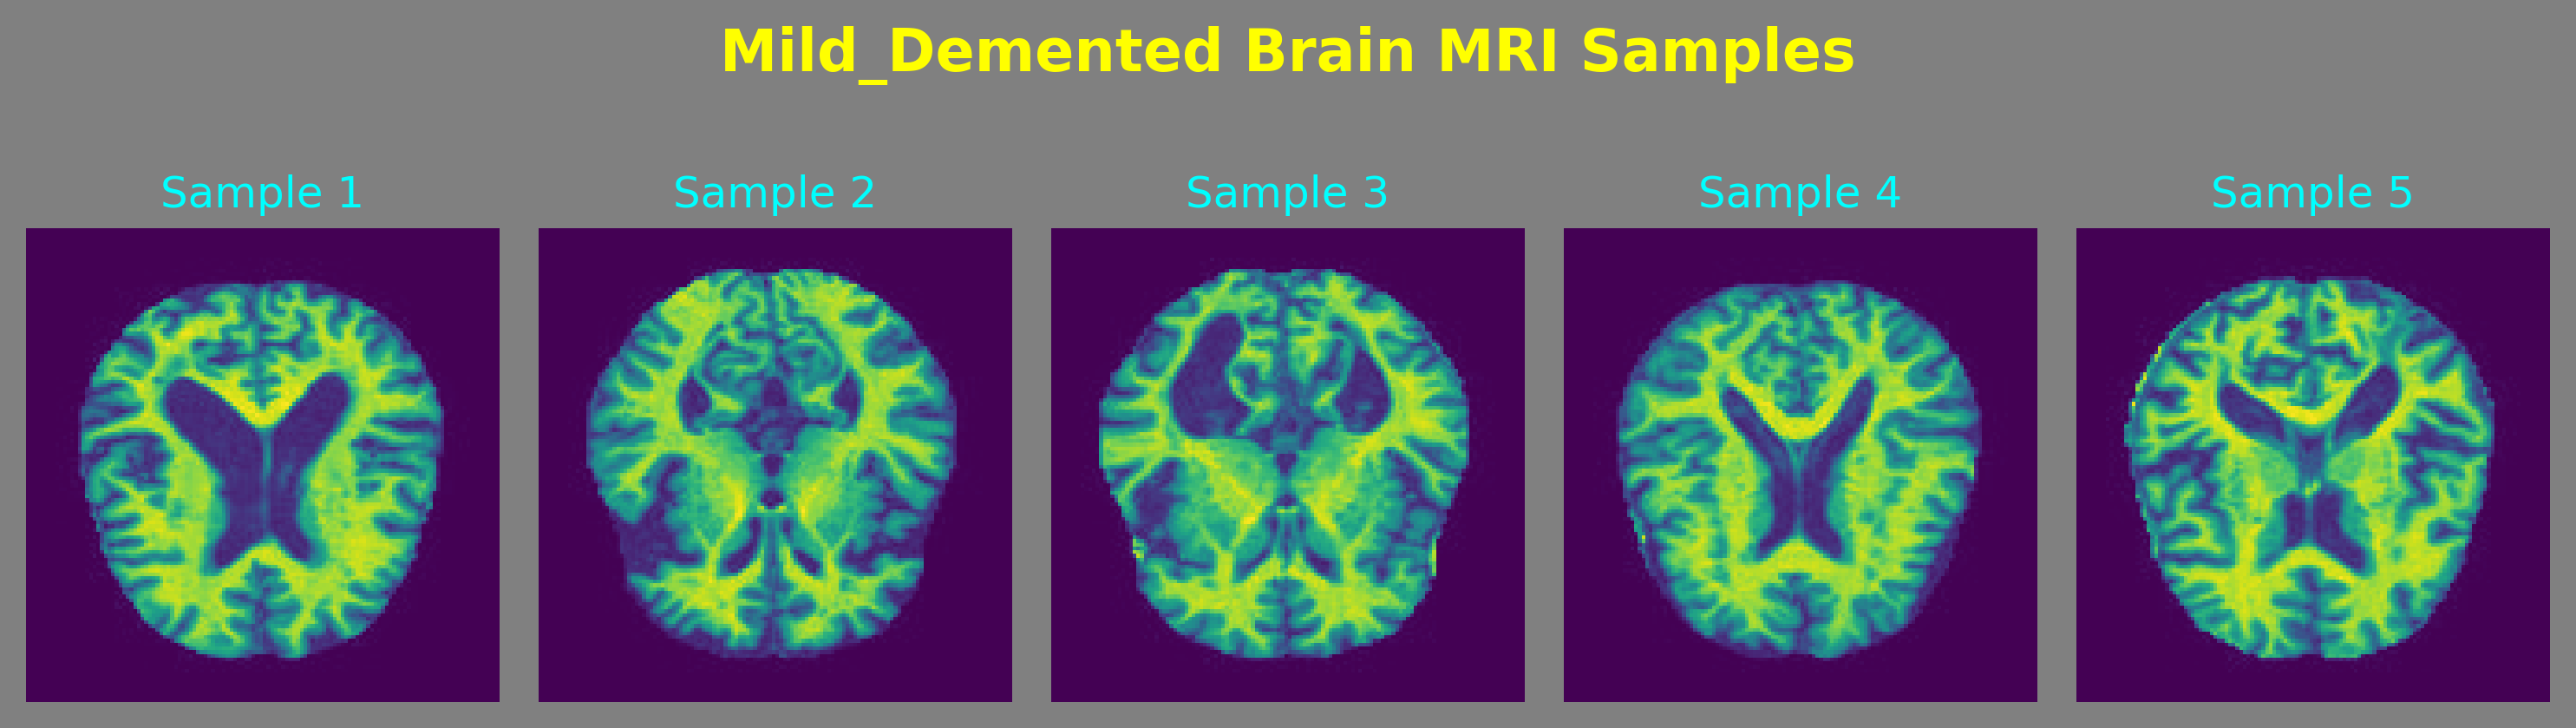

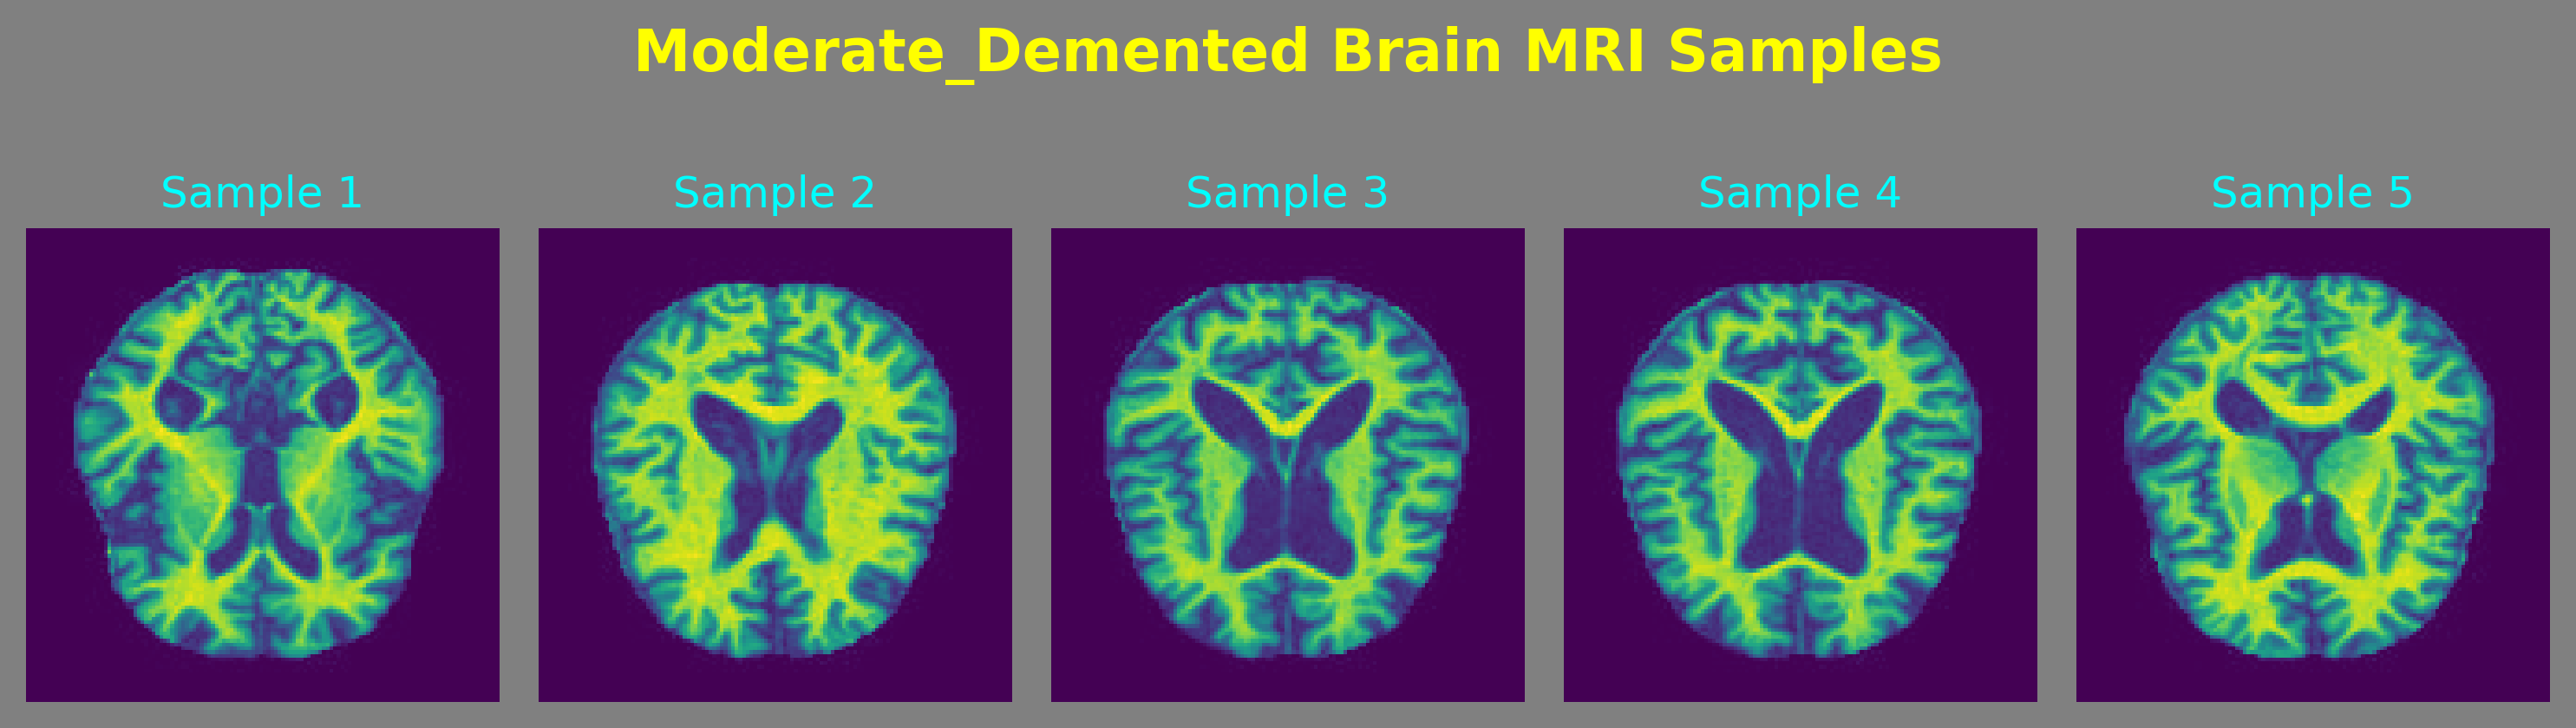

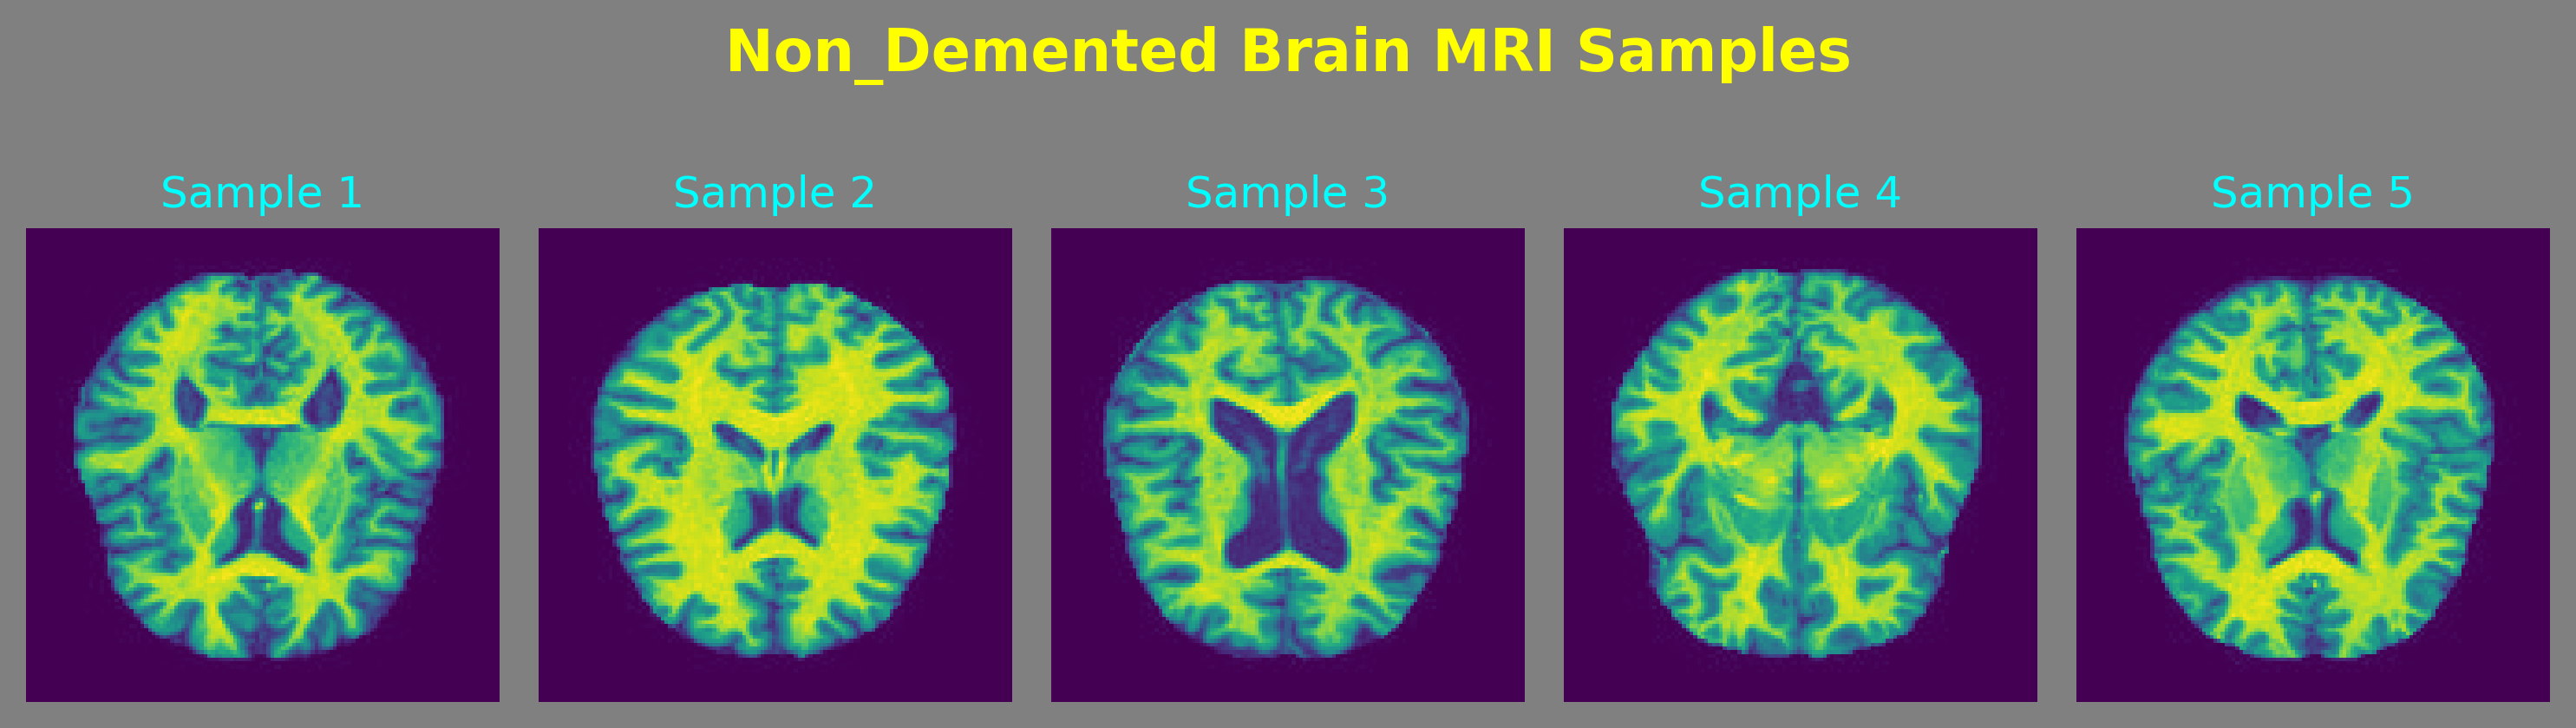

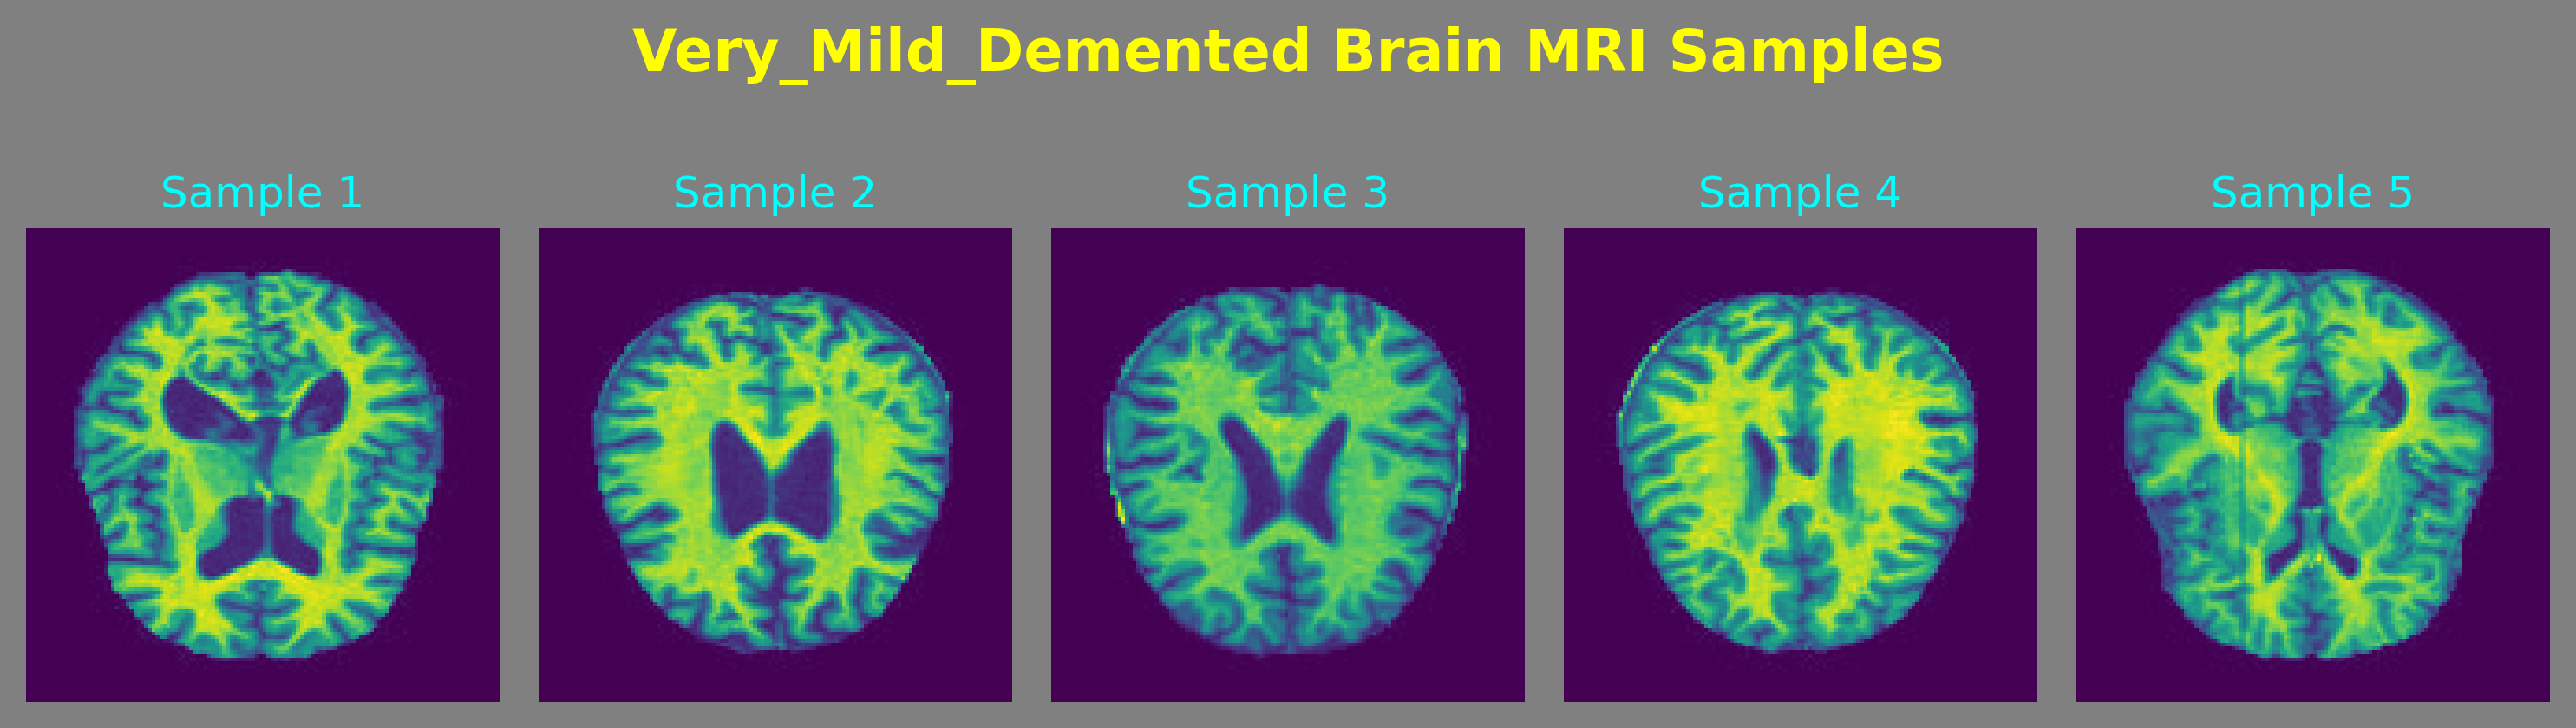

In [ ]:
def sample_bringer(path, target, num_samples=5):

    class_path = os.path.join(path, target)

    image_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    fig, ax = plt.subplots(1, num_samples, facecolor="gray")
    fig.suptitle(f'{target} Brain MRI Samples', color="yellow",fontsize=16, fontweight='bold', y=0.75)

    for i in range(num_samples):
        image_path = os.path.join(class_path, image_files[i])
        img = mpimg.imread(image_path)

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f'Sample {i+1}', color="aqua")

    plt.tight_layout()

for target in class_names:
    sample_bringer(PATH, target=target)

# Preprocessing Data

In [ ]:
alz_dict = {index: img for index, img in enumerate(data.class_names)}

class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())

    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="gray")
        fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", color="yellow",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(alz_dict[class_no], color="aqua")
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])

    def train_test_val_split(self, train_size, val_size, test_size):

        train = int(len(self.data)*train_size)
        test = int(len(self.data)*test_size)
        val = int(len(self.data)*val_size)

        train_data = self.data.take(train)
        val_data = self.data.skip(train).take(val)
        test_data = self.data.skip(train+val).take(test)

        return train_data, val_data, test_data


    def visualize_class_distribution(self, train_data, val_data, test_data):
        train_labels = [label.numpy() for _, label in train_data.unbatch()]
        val_labels = [label.numpy() for _, label in val_data.unbatch()]
        test_labels = [label.numpy() for _, label in test_data.unbatch()]

        unique_labels = list(set(train_labels + val_labels + test_labels))
        unique_labels.sort()

        train_counts = [train_labels.count(label) for label in unique_labels]
        val_counts = [val_labels.count(label) for label in unique_labels]
        test_counts = [test_labels.count(label) for label in unique_labels]

        width = 0.2
        x = np.arange(len(unique_labels))

        fig, ax = plt.subplots(figsize=(12, 6))
        plt.style.use('ggplot')
        ax.bar(x - width, train_counts, width, label='Train Data', color='skyblue')
        ax.bar(x, val_counts, width, label='Validation Data', color='lightgreen')
        ax.bar(x + width, test_counts, width, label='Test Data', color='lightcoral')

        ax.set_xticks(x)
        ax.set_xticklabels([alz_dict[label] for label in unique_labels], rotation=45, ha="right")
        ax.set_xlabel('Alzheimer Classes')
        ax.set_ylabel('Number of Samples')
        ax.legend()

        # Adding data labels on top of the bars
        for i, v in enumerate(train_counts):
            ax.text(i - width, v + 10, str(v), color='black', ha='center', va='bottom')
        for i, v in enumerate(val_counts):
            ax.text(i, v + 10, str(v), color='black', ha='center', va='bottom')
        for i, v in enumerate(test_counts):
            ax.text(i + width, v + 10, str(v), color='black', ha='center', va='bottom')

        plt.title('Distribution of Data for Each Class')
        plt.tight_layout()
        plt.show()

Min and max pixel values in the batch -> 0.0 & 1.0


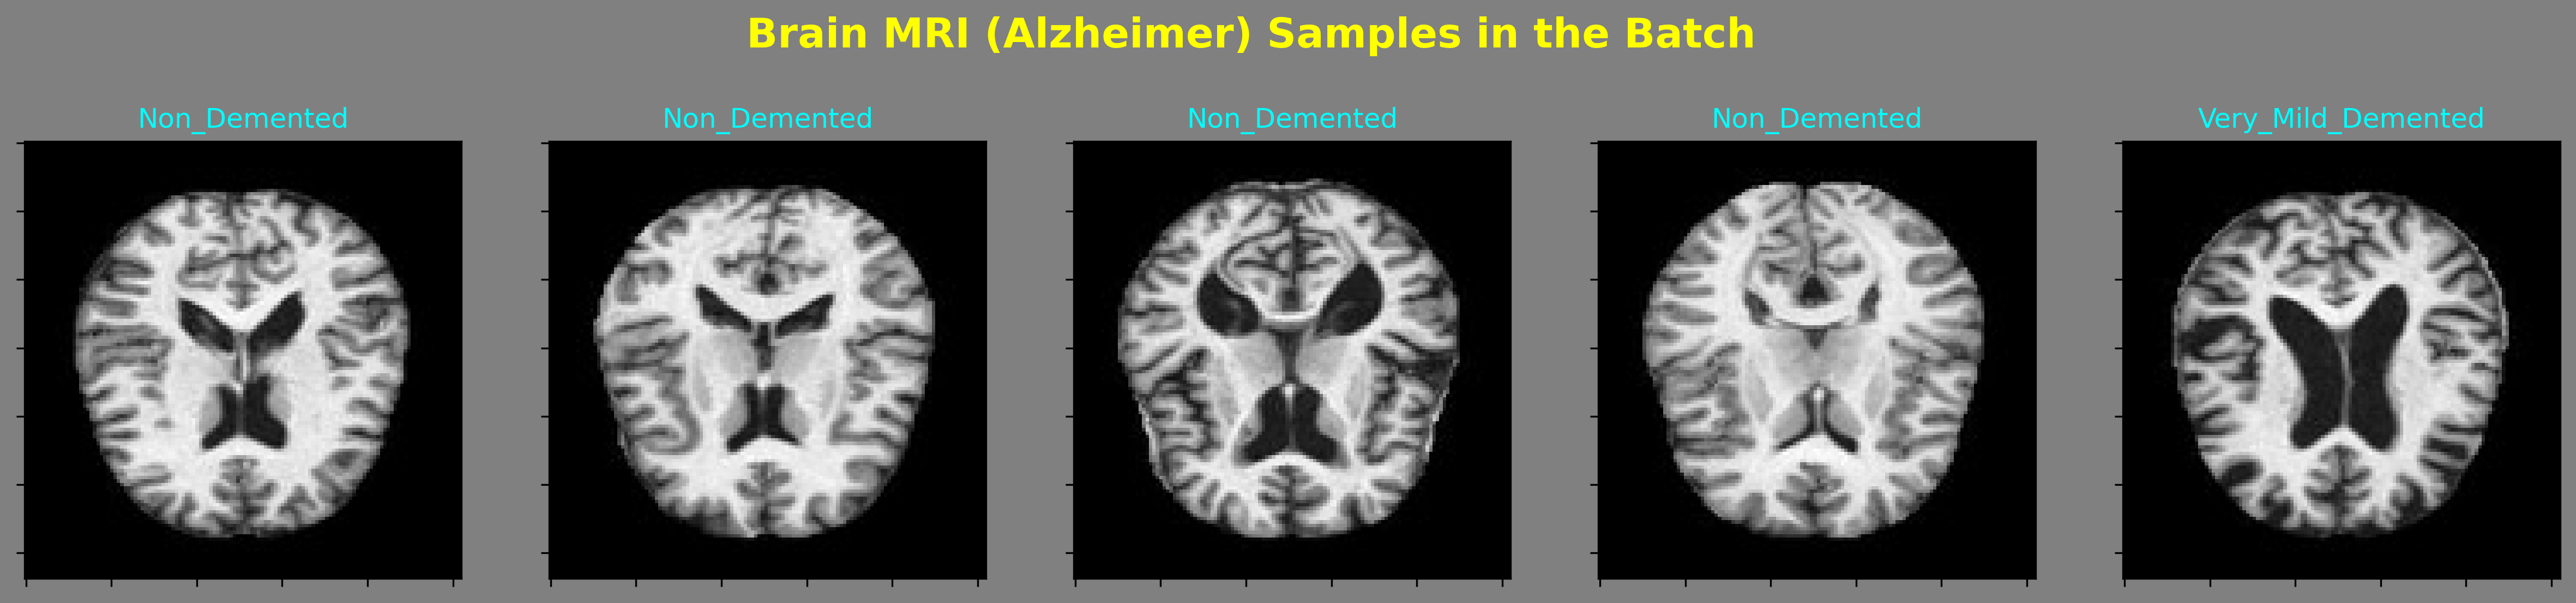

In [ ]:
process = Process(data)
process.create_new_batch()
process.show_batch_images(number_of_images=5)

In [ ]:
train_data, val_data, test_data= process.train_test_val_split(train_size=0.8, val_size=0.1, test_size=0.2)

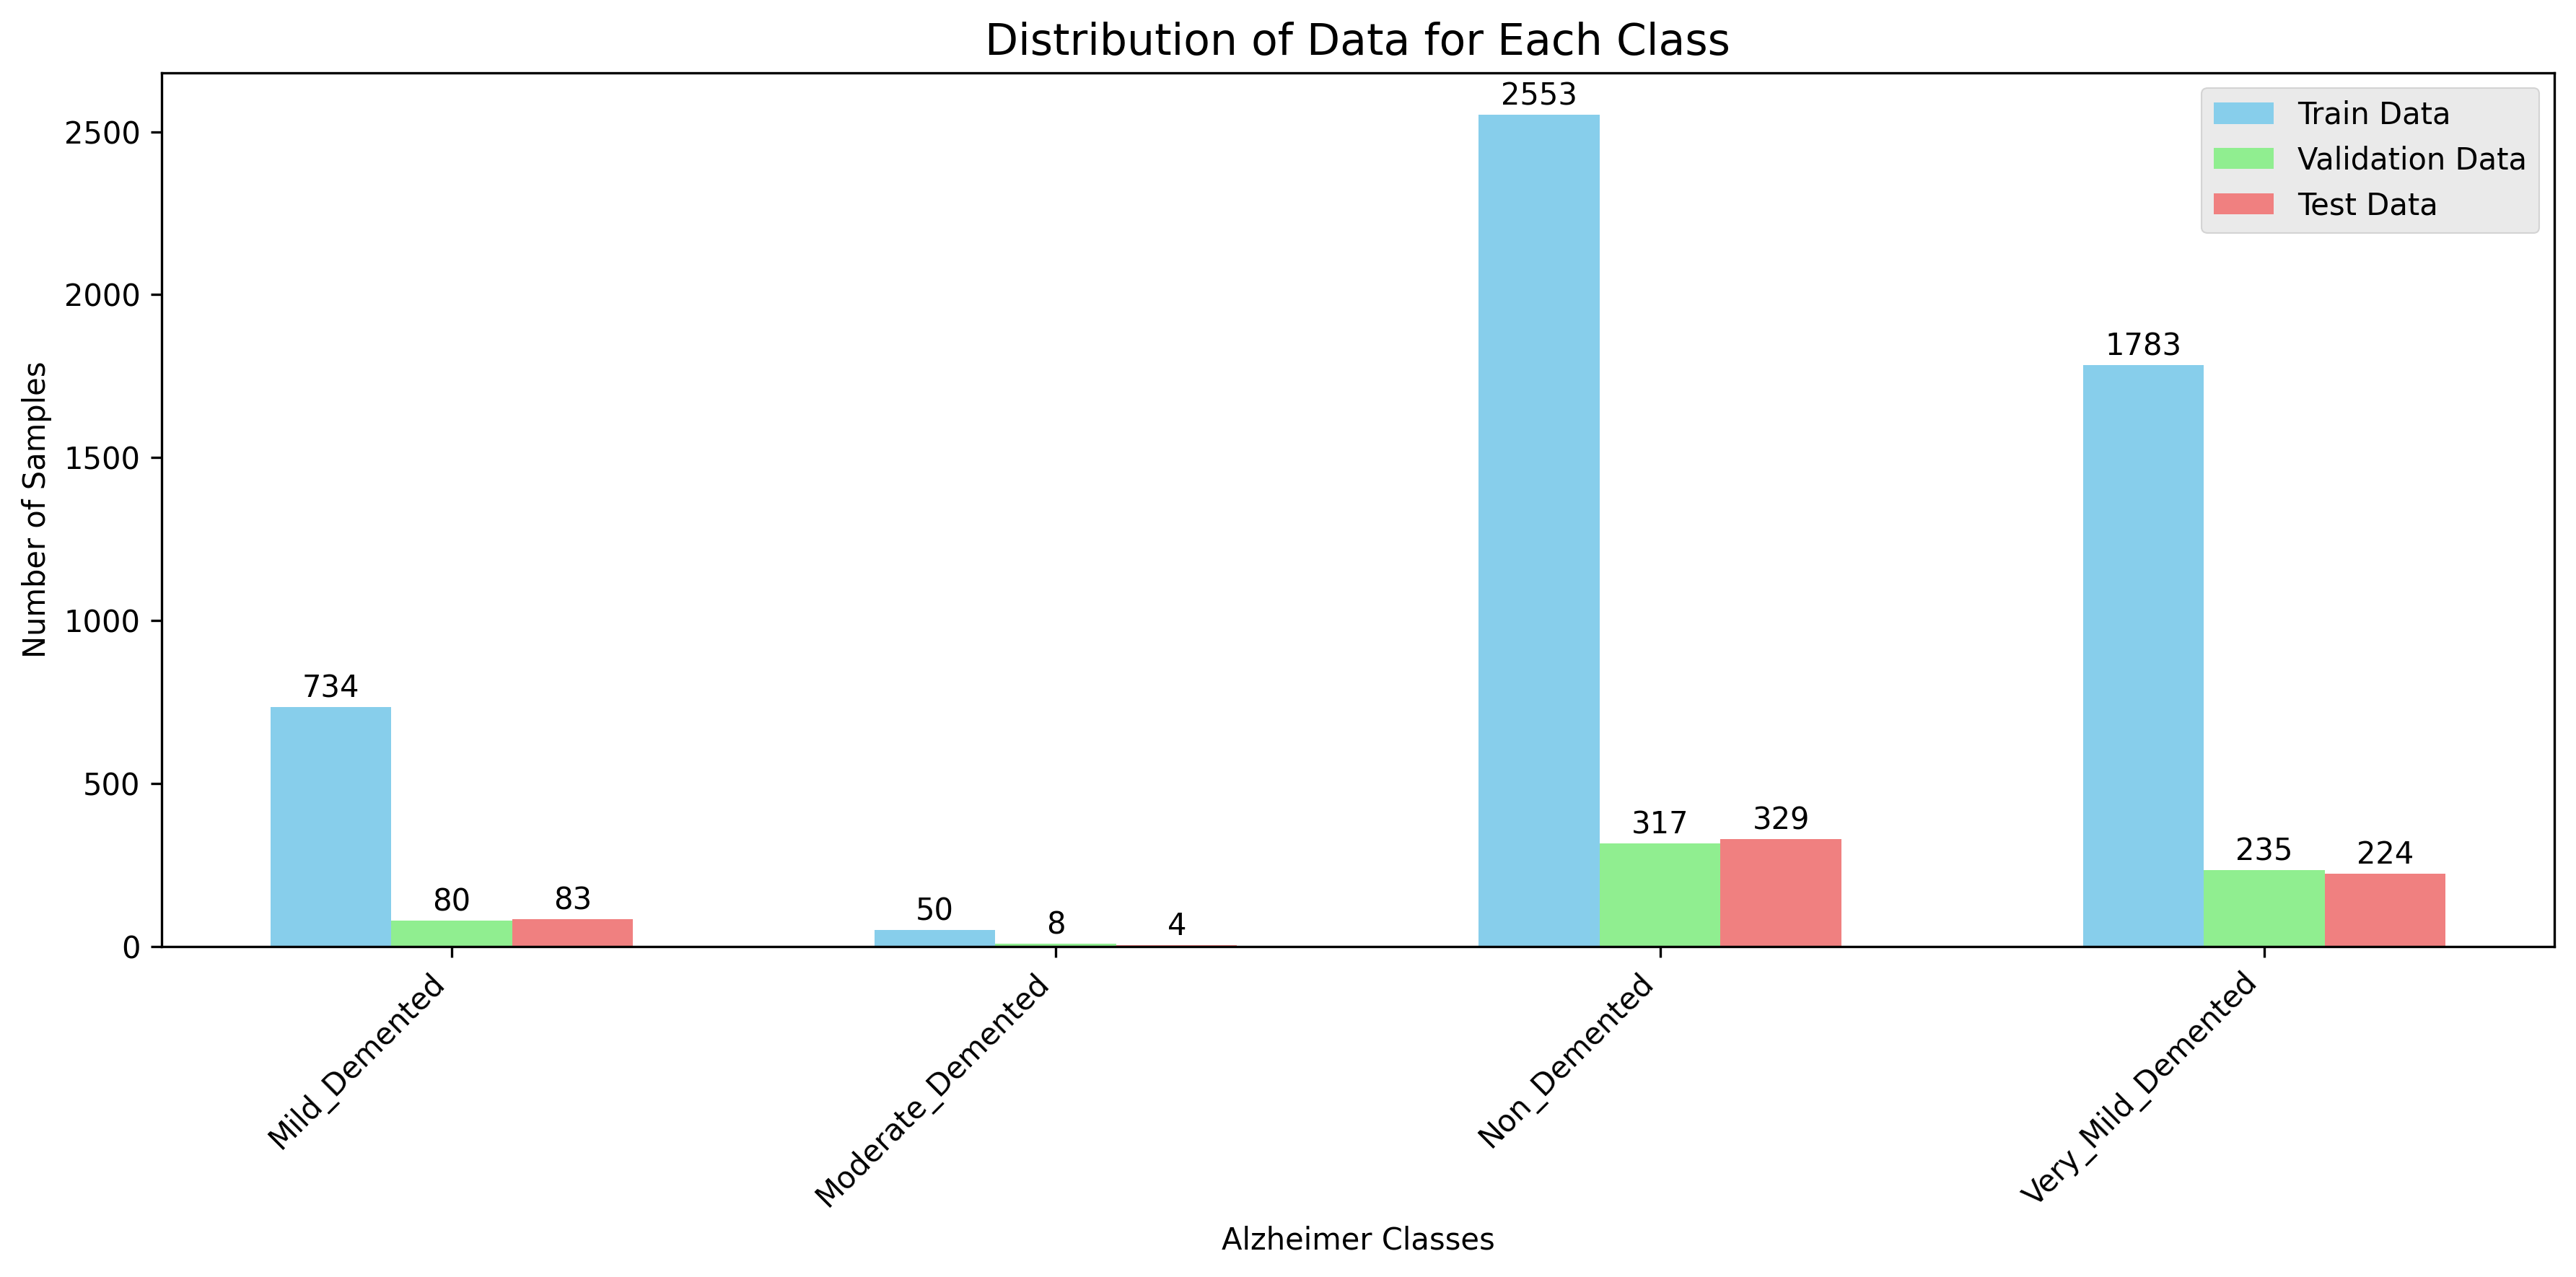

In [ ]:
process.visualize_class_distribution(train_data, val_data, test_data)

# Solve Imbalanced Dataset

In [ ]:
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)

class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))

# Model Building

In [ ]:
def build_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal',
                     input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation="relu", kernel_initializer='he_normal'))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    model.summary()
    return model

model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Callbacks and Training</h2>

In [ ]:
def checkpoint_callback():

    checkpoint_filepath = '/tmp/checkpoint'

    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           frequency='epoch',
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback


EPOCHS = 20
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

In [ ]:
history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data, callbacks=[checkpoint_callback])

Epoch 1/20
160/160 [==============================] - ETA: 0s - loss: 1.2793 - accuracy: 0.5295
Epoch 1: val_accuracy improved from -inf to 0.55313, saving model to /tmp/checkpoint
160/160 [==============================] - 17s 32ms/step - loss: 1.2793 - accuracy: 0.5295 - val_loss: 0.9036 - val_accuracy: 0.5531
Epoch 2/20
159/160 [============================>.] - ETA: 0s - loss: 0.7843 - accuracy: 0.6305
Epoch 2: val_accuracy improved from 0.55313 to 0.64688, saving model to /tmp/checkpoint
160/160 [==============================] - 7s 45ms/step - loss: 0.7830 - accuracy: 0.6316 - val_loss: 0.7392 - val_accuracy: 0.6469
Epoch 3/20
157/160 [============================>.] - ETA: 0s - loss: 0.5636 - accuracy: 0.7570
Epoch 3: val_accuracy improved from 0.64688 to 0.84375, saving model to /tmp/checkpoint
160/160 [==============================] - 5s 29ms/step - loss: 0.5609 - accuracy: 0.7586 - val_loss: 0.4285 - val_accuracy: 0.8438
Epoch 4/20
160/160 [==============================] - 

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Loss and Accuracy</h2>

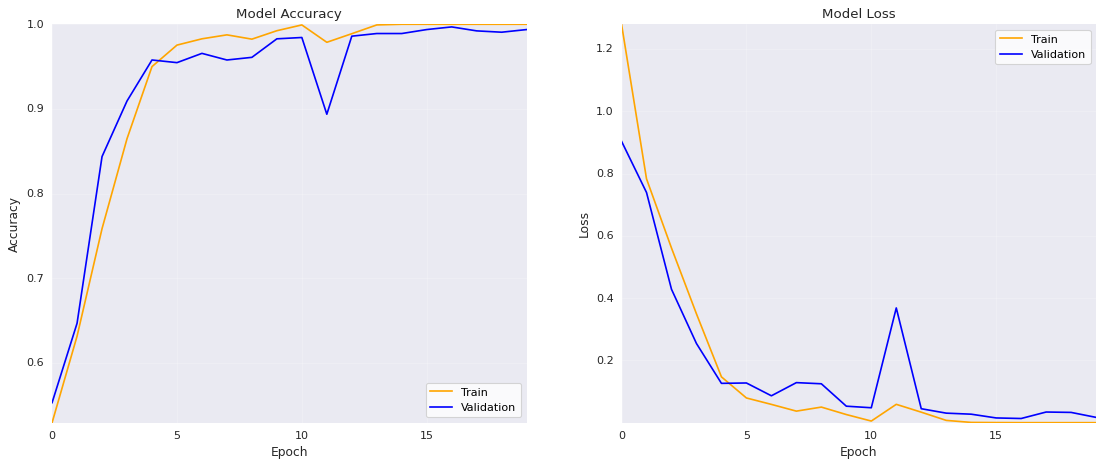

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))
plt.style.use('default')

ax[0].plot(history.history['accuracy'], color='orange')
ax[0].plot(history.history['val_accuracy'], color='blue')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

ax[1].plot(history.history['loss'], color='orange')
ax[1].plot(history.history['val_loss'], color='blue')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()


# Evaluate Model

In [ ]:
import numpy as np

y_pred = []
y_true = []

for images, labels in test_data:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels)

y_pred = np.array(y_pred)
y_true = np.array(y_true)


1/1 [==============================] - 0s 21ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Accuracy     : ", accuracy*100, "%"))
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")

------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Accuracy     : 98.75%
Precision     : 98.75%
Recall        : 98.75%
F1-Score      : 98.74%
------------------------------------------------------------------------------------------





<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Evaluating Test Data</h2>

In [ ]:
model.evaluate(test_data)

20/20 [==============================] - 1s 10ms/step - loss: 0.0536 - accuracy: 0.9875


[0.05356361344456673, 0.987500011920929]

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Classification Report</h2>

In [ ]:
predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.95      0.98        83
 Moderate_Demented       1.00      1.00      1.00         5
      Non_Demented       0.98      1.00      0.99       320
Very_Mild_Demented       1.00      0.99      0.99       232

          accuracy                           0.99       640
         macro avg       1.00      0.99      0.99       640
      weighted avg       0.99      0.99      0.99       640



<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Confusion Matrix</h2>

Text(286.1666666666666, 0.5, 'True')

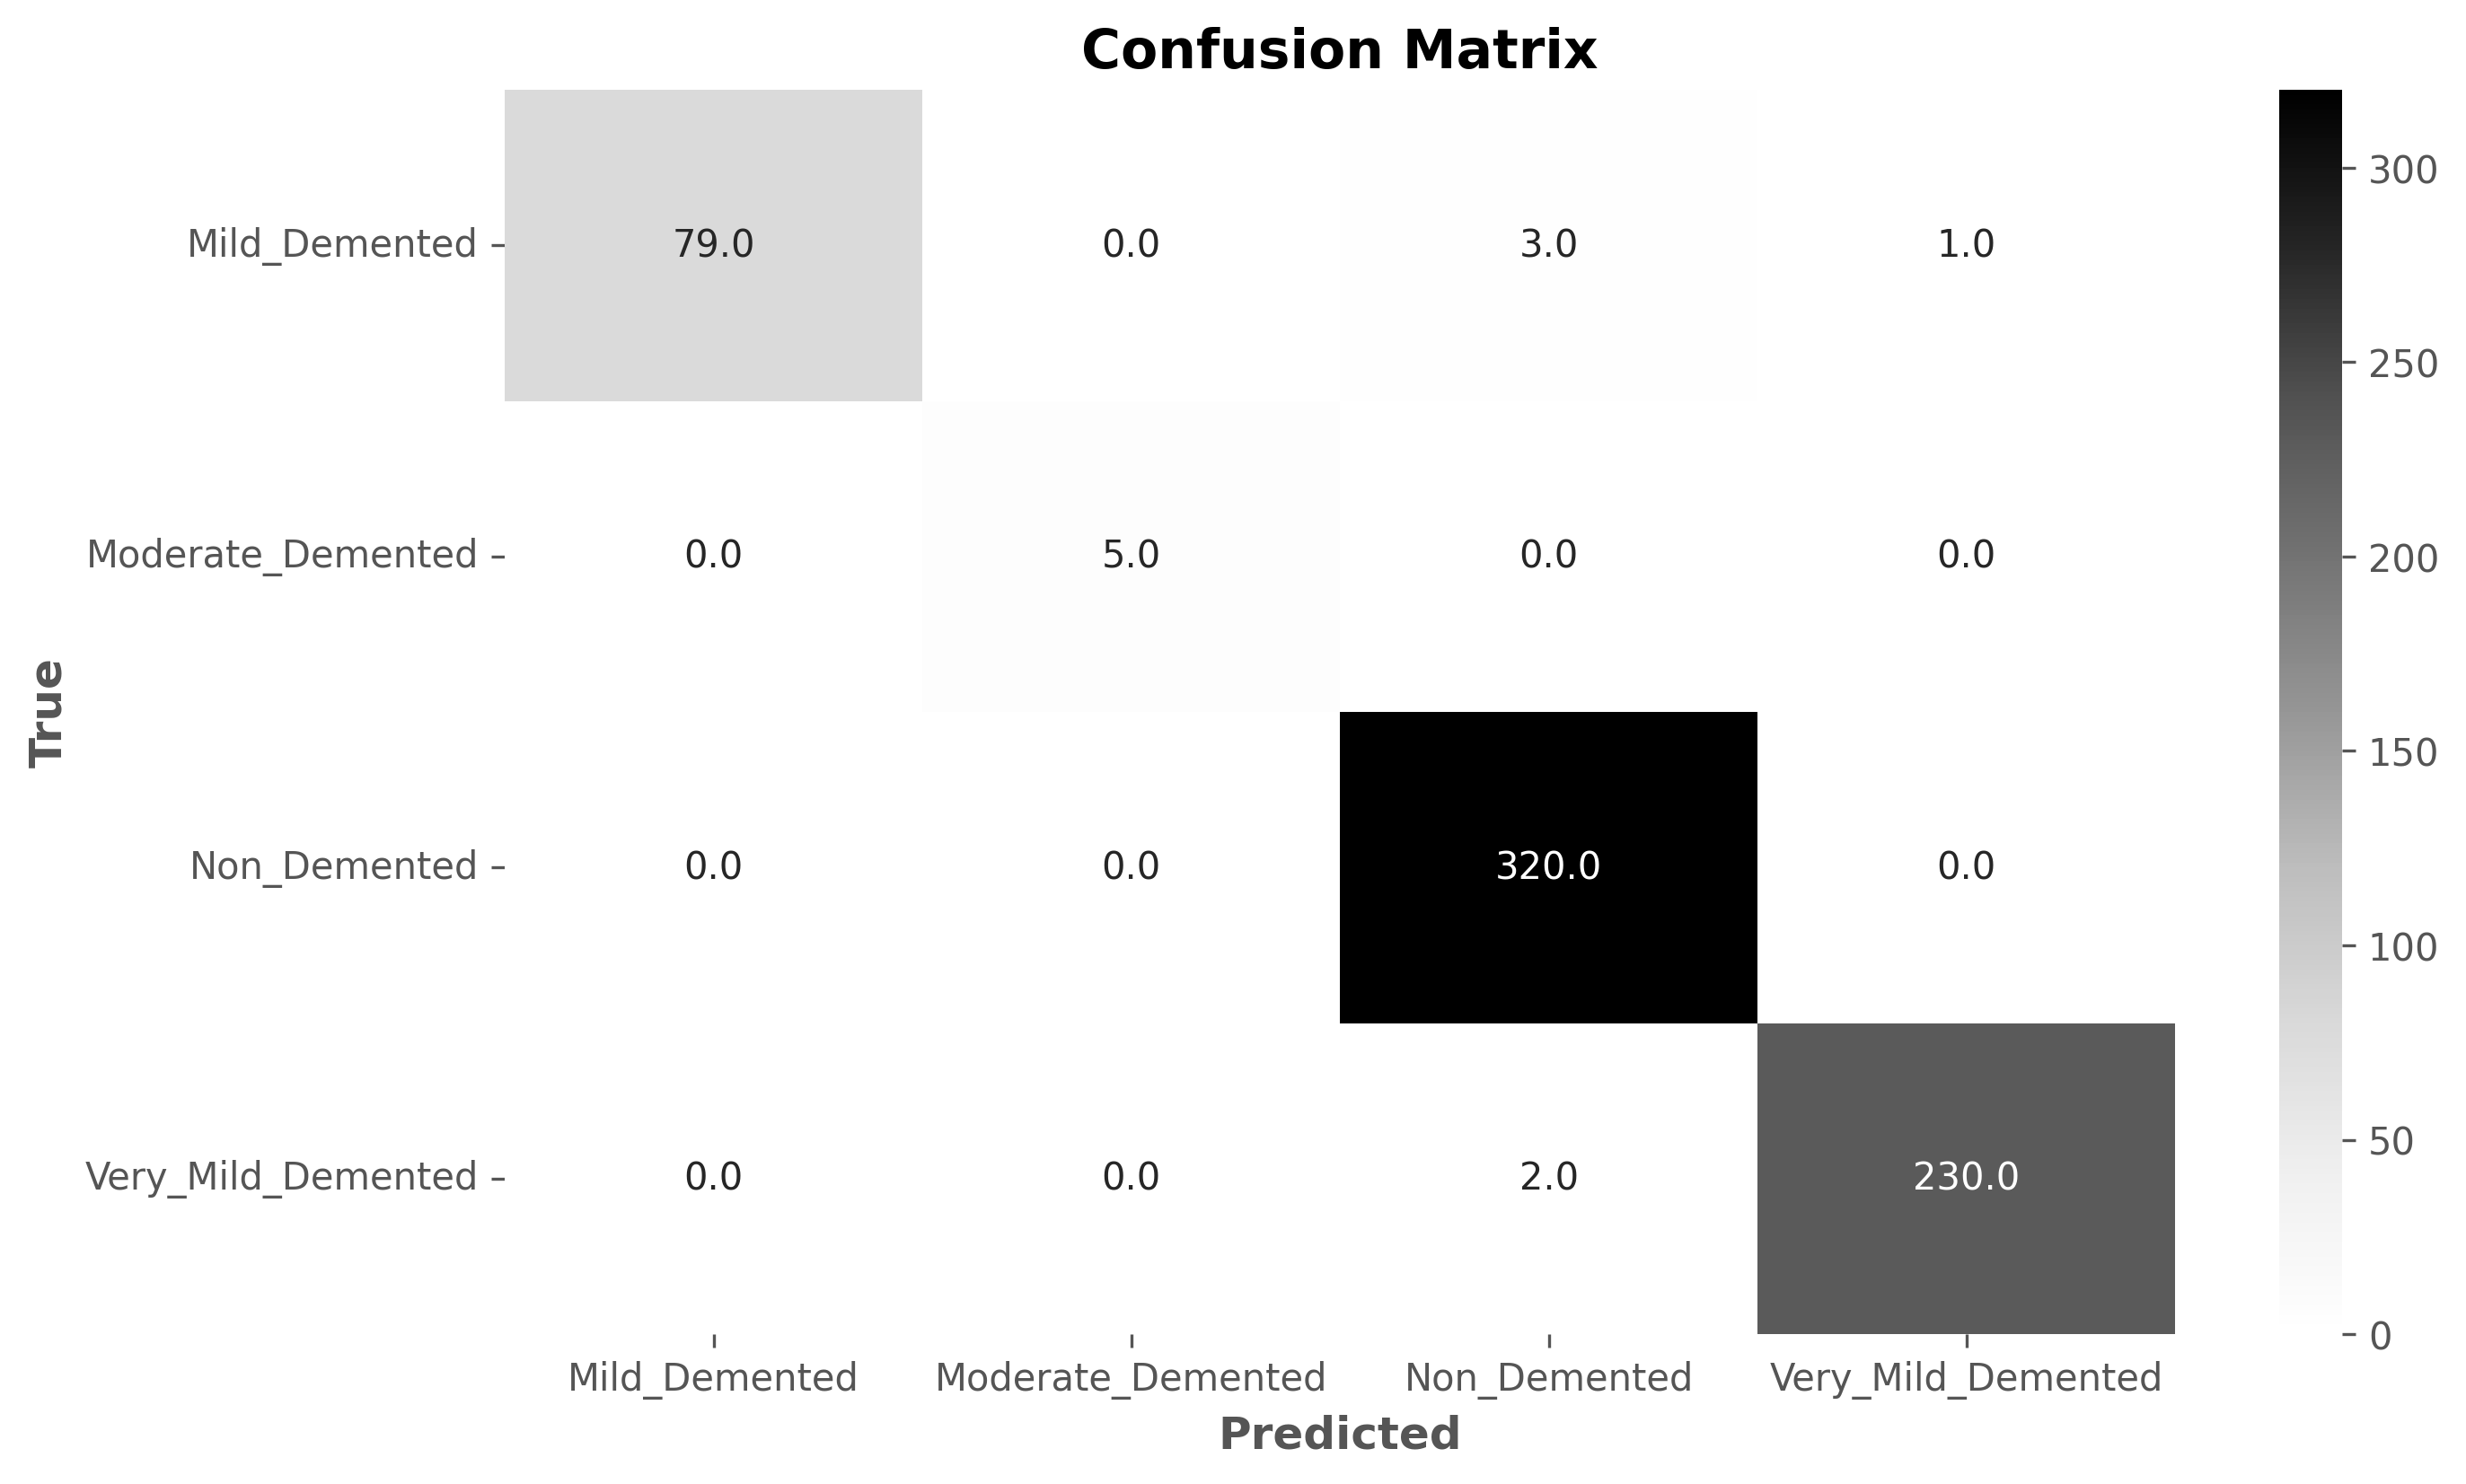

In [ ]:
cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="Greys", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")

<h2 style="color: white; background-color: dodgerblue; font-weight: bold; text-align: center; border:3px solid black;">Comparing Predicted Classes with the Actual Classes from the Test Data</h2>

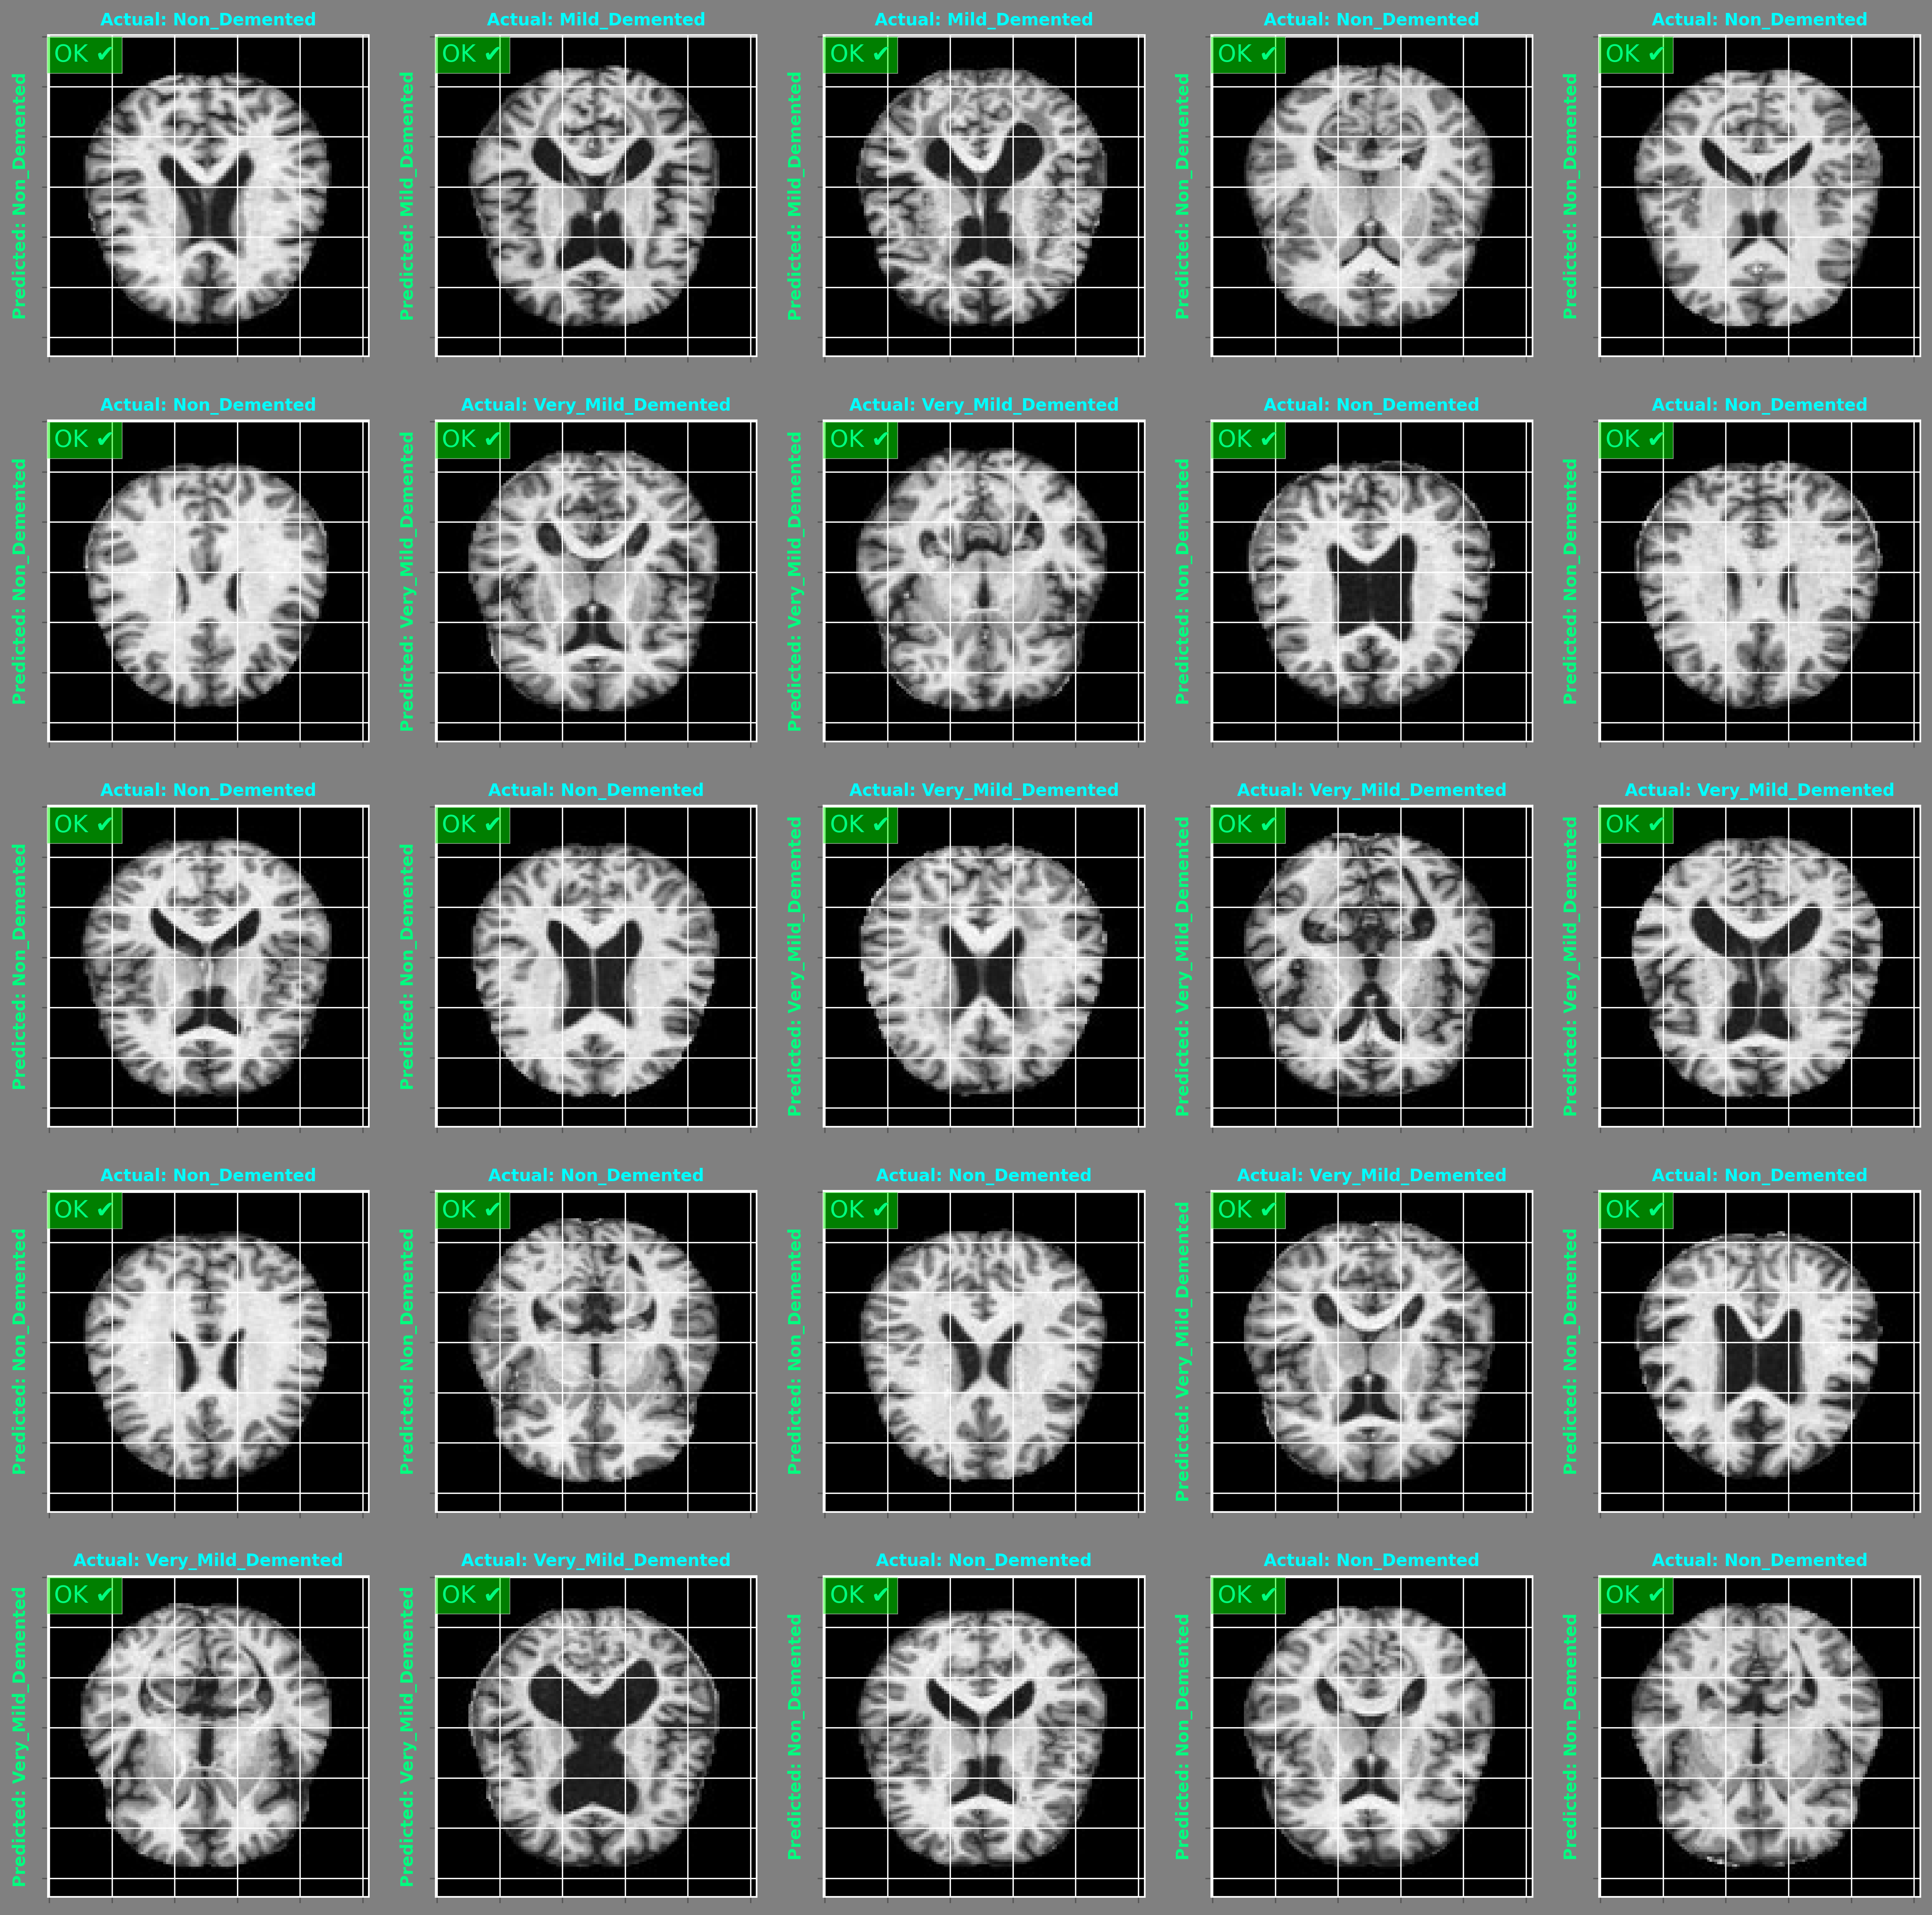

In [ ]:
plt.figure(figsize=(20, 20), facecolor="gray")
for images, labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        predictions = model.predict(tf.expand_dims(images[i], 0), verbose=0)
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="springgreen", fontweight="bold", fontsize=10)
            ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=14)
            ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))

        else:
            plt.title("Actual: "+class_names[labels[i]], color="aqua", fontweight="bold", fontsize=10)
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], color="maroon", fontweight="bold", fontsize=10)
            nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=14)
            nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])

In [ ]:
model.save('alzheimer_model99.h5')